# Sequence Model with Attention for Addition Learning

- In this unit, we will practice on the sequence-to-sequence model using a naive example of numbers addition.
- The inputs are sequences of two numbers adding together (e.g., 123+23); the outputs are the correct answers, i.e., the sum of the two numbers (i.e., 125).
- This type of sequence model is also referred to as Encoder-Decoder Models.
- This task is to simulate the machine translation task (i.e, the sequence to the left of the equation is the source language while the sequence to the right of the equation is the target language).
- In particular, we will implement not only a vanilla RNN-based sequence-to-sequence model but also a few extended variants of the RNN, including:
    - GRU
    - Bidirectional GRU
    - Peeky Decoder
    - Attention-based Decoder

## Set up Dependencies

In [1]:
import re
import tensorflow
import numpy as np
from random import randint

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [2]:
print('Tensorflow Version: ', tensorflow.__version__)

Tensorflow Version:  2.4.1


## Deep Learning Hyperparameters

In [3]:
batch_size = 128  # Batch size for training.
epochs = 30  # Epochs for training
latent_dim = 256  # Encoder-Decoder latent dimensions

## Data

- Please download the data set from `demo_data/addition-student-version.csv`, where each line is a training sample, consisting of the input sequence (e.g., `16+75`) and the target sequence (e.g., `91`) separated by a comma.
- We load the data and add initial and ending token to all the target sequences (`_`).

In [4]:
data_path = '../../../RepositoryData/data/deep-learning-2/addition-student-version.csv'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

lines = [l for l in lines if l!='']
    
input_texts = [l.split(',')[0] for l in lines]
target_texts = [l.split(',')[-1].strip() for l in lines]

target_texts = ['_' + sent + '_' for sent in target_texts]

np.random.seed(123)

inds = np.arange(len(input_texts))
np.random.shuffle(inds)

print(input_texts[:5])
print(target_texts[:5])
print('Data Size:', len(input_texts))

['16+75', '52+607', '75+22', '63+22', '795+3']
['_91_', '_659_', '_97_', '_85_', '_798_']
Data Size: 50000


## Train-Test Split

In [5]:
train_test_ratio = 0.9
train_size = int(round(len(lines) * train_test_ratio))
train_inds = inds[:train_size]
test_inds = inds[train_size:]

tr_input_texts = [input_texts[ti] for ti in train_inds]
tr_target_texts = [target_texts[ti] for ti in train_inds]

ts_input_texts = [input_texts[ti] for ti in test_inds]
ts_target_texts = [target_texts[ti] for ti in test_inds]

In [6]:
tr_input_texts[:10]

['27+673',
 '153+27',
 '93+901',
 '243+678',
 '269+46',
 '235+891',
 '46+290',
 '324+947',
 '721+49',
 '535+7']

In [7]:
tr_target_texts[:10]

['_700_',
 '_180_',
 '_994_',
 '_921_',
 '_315_',
 '_1126_',
 '_336_',
 '_1271_',
 '_770_',
 '_542_']

In [8]:
print('Number of Samples:', len(lines))
print('Number of Samples in Training:', len(tr_input_texts))
print('Number of Samples in Testing:', len(ts_input_texts))

Number of Samples: 50000
Number of Samples in Training: 45000
Number of Samples in Testing: 5000


## Data Preprocessing

![](../images/text-seq-onehot-embedding.jpeg)

### Text to Sequences

- Tokenization of input and target texts invovles the following important steps:
    - Create a `Tokenizer`
    - Fit the `Tokenizer` on the training sets
    - Tokenize input and target texts of the training set into sequences
    - Identify the maxlen of the input and target sequences 
    - Pad input and target sequences to uniform lengths
- Note that we need to create a **character-based** `Tokenizer`.
- There will be two Tokenizers, one for input texts and the other for target texts.

In [9]:
# """ Defining tokenizers """
input_tokenizer = Tokenizer(char_level=True)
input_tokenizer.fit_on_texts(tr_input_texts)
encoder_input_sequences = input_tokenizer.texts_to_sequences(tr_input_texts)
input_maxlen = np.max([len(l) for l in encoder_input_sequences])
encoder_input_sequences = pad_sequences(encoder_input_sequences,
                                        padding='post',
                                        maxlen=input_maxlen)

target_tokenizer = Tokenizer(char_level=True)
target_tokenizer.fit_on_texts(tr_target_texts)
target_sequences = target_tokenizer.texts_to_sequences(tr_target_texts)
target_maxlen = np.max([len(l) for l in target_sequences])
target_sequences = pad_sequences(target_sequences,
                                 padding='post',
                                 maxlen=target_maxlen)

In [10]:
# Shapes of Input and Target Sequences
print(encoder_input_sequences.shape)
print(target_sequences.shape)

(45000, 7)
(45000, 6)


In [11]:
# ### vocab size
input_vsize = max(input_tokenizer.index_word.keys()) + 1
target_vsize = max(target_tokenizer.index_word.keys()) + 1

:::{note}
The plus 1 for vocabulary size is to include the padding character, whose index is the reserved `0`.
:::

In [12]:
print(input_vsize)
print(target_vsize)

12
12


In [13]:
print(tr_input_texts[:3])
print(encoder_input_sequences[:3])

['27+673', '153+27', '93+901']
[[ 9 10  1  7 10  5  0]
 [ 8  6  5  1  9 10  0]
 [ 2  5  1  2 11  8  0]]


In [14]:
input_tokenizer.word_index

{'+': 1,
 '9': 2,
 '4': 3,
 '8': 4,
 '3': 5,
 '5': 6,
 '6': 7,
 '1': 8,
 '2': 9,
 '7': 10,
 '0': 11}

In [15]:
print(tr_target_texts[:3])
print(target_sequences[:3])

['_700_', '_180_', '_994_']
[[ 1  4 11 11  1  0]
 [ 1  2 10 11  1  0]
 [ 1  7  7  8  1  0]]


In [16]:
target_tokenizer.word_index

{'_': 1,
 '1': 2,
 '2': 3,
 '7': 4,
 '6': 5,
 '3': 6,
 '9': 7,
 '4': 8,
 '5': 9,
 '8': 10,
 '0': 11}

### Special Considerations for Decoder's Input and Output

![](../images/seq2seq-vanilla-rnn.jpeg)

- In the training stage, we give the Decoder the correct target sequences for **teacher forcing**.
- Input and Output Sequences for Decoder
    - Decoder input and output sequences have one time-step difference (i.e., the decoder's output at $t-1$ is the decoder's input at $t$)
    - We create decoder input and output sequences as different sets of data.

In [17]:
decoder_input_sequences = target_sequences[:,:-1]
decoder_output_sequences = target_sequences[:,1:]
print(decoder_input_sequences[:5])
print(decoder_output_sequences[:5])

[[ 1  4 11 11  1]
 [ 1  2 10 11  1]
 [ 1  7  7  8  1]
 [ 1  7  3  2  1]
 [ 1  6  2  9  1]]
[[ 4 11 11  1  0]
 [ 2 10 11  1  0]
 [ 7  7  8  1  0]
 [ 7  3  2  1  0]
 [ 6  2  9  1  0]]


### Sequences to One-Hot Encoding

- To simplify the matter, we convert each sequence/integer token into one-hot encoding, which will be the input of the Encoder directly. 
- Normally we would add an Embedding layer to convert sequence tokens to embeddings before sending them to the Encoder.
- Please note that this step renders the text representation of the entire training data from 2D (`batch_size`, `max_length`) to 3D tensors (`batch_size`, `max_length`, `vocab_size`).

![](../images/text-seq-onehot-embedding.jpeg)

:::{note}
For neural machine translations, the vocabulary sizes of the input and target languages are usually very large. It is more effective to implement an **Embedding** layer to convert sequences (integers) into embeddings, rather than one-hot encodings.

For this tutorial, we have a limited vocabulary size (only digits and math symbols). One-hot encodings should be fine.

However, in the assignment, you will practice on how to add embedding layers for both Encoder and Decoder.
:::

In [18]:
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)
print(decoder_output_sequences.shape)

(45000, 7)
(45000, 5)
(45000, 5)


In [19]:
encoder_input_onehot = to_categorical(encoder_input_sequences,
                                      num_classes=input_vsize)
decoder_input_onehot = to_categorical(decoder_input_sequences,
                                      num_classes=target_vsize)
decoder_output_onehot = to_categorical(decoder_output_sequences,
                                       num_classes=target_vsize)

In [20]:
print(encoder_input_onehot.shape)
print(decoder_input_onehot.shape)
print(decoder_output_onehot.shape)

(45000, 7, 12)
(45000, 5, 12)
(45000, 5, 12)


### Token Indices

- We create the integer-to-character dictionaries for later use.
- Two dictionaries, one for the input sequence and one for the target sequence.

In [21]:
""" Index2word """
enc_index2word = dict(
    zip(input_tokenizer.word_index.values(),
        input_tokenizer.word_index.keys()))
dec_index2word = dict(
    zip(target_tokenizer.word_index.values(),
        target_tokenizer.word_index.keys()))

In [22]:
enc_index2word

{1: '+',
 2: '9',
 3: '4',
 4: '8',
 5: '3',
 6: '5',
 7: '6',
 8: '1',
 9: '2',
 10: '7',
 11: '0'}

In [23]:
dec_index2word

{1: '_',
 2: '1',
 3: '2',
 4: '7',
 5: '6',
 6: '3',
 7: '9',
 8: '4',
 9: '5',
 10: '8',
 11: '0'}

In [24]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

## Model Training

- Define the model architecture
- Train the model

- Sequence-to-Sequence can go from simple RNNs to complex models with attention mechanisms.
- In this tutorial, we will try the following:
    - Sequence-to-sequence model with **vanilla RNN** Encoder and Decoder
    - Sequence-to-sequence model with **GRU** Encoder and Decoder
    - Sequence-to-sequence model with **bidirectional** RNN Encoder
    - Sequence-to-sequence model with **peeky** Decoder
    - Sequence-to-sequence model with **attention-based** Decoder

- Sequential vs. Functional API in `keras`
    - We have been using the Sequential API to create the network models, where each layer's output is the input of the subsequent layer.
    - However, for Encoder-Decoder Models, sometimes not all the outputs of the previous layer are the inputs of the subsequent layer.
    - We need more flexibility in the ways of connecting the inputs and outputs of the model layers.
    - Therefore, here we will use the Functional API for model definition.

## Model 1 (Vanilla RNN)

![](../images/seq2seq-vanilla-rnn.jpeg)

### Define Model

- Important Highlights:
    - In the training stage, we feed the decoder the correct answer at each time step as the input sequence. 
    - In the testing stage, the decoder will take the hidden state from the previous time step as the input sequence.
    - This type of training is referred to as **teacher forcing** learning strategy. This can help the model converge more effectively.
    - The decoder uses encoder's last hidden state as the initial hidden state.

In [25]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder RNN
    ## first return is the hidden states of all timesteps of encoder
    ## second return is the last hidden state of encoder
encoder_rnn = SimpleRNN(latent_dim,
                        return_sequences=True,
                        return_state=True,
                        name='encoder_rnn')
_, encoder_state = encoder_rnn(encoder_inputs)


# Decoder RNN
    ## using `encoder_state` (last h) as initial state.
    ## using `decoder_inputs` for teacher forcing learning
decoder_rnn = SimpleRNN(latent_dim,
                        return_sequences=True,
                        return_state=True,
                        name='decoder_rnn')
decoder_out, _ = decoder_rnn(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model1 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 12)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 12)]      0                                            
__________________________________________________________________________________________________
encoder_rnn (SimpleRNN)         [(None, 7, 256), (No 68864       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_rnn (SimpleRNN)         [(None, 5, 256), (No 68864       decoder_inputs[0][0]             
                                                                 encoder_rnn[0][1]            

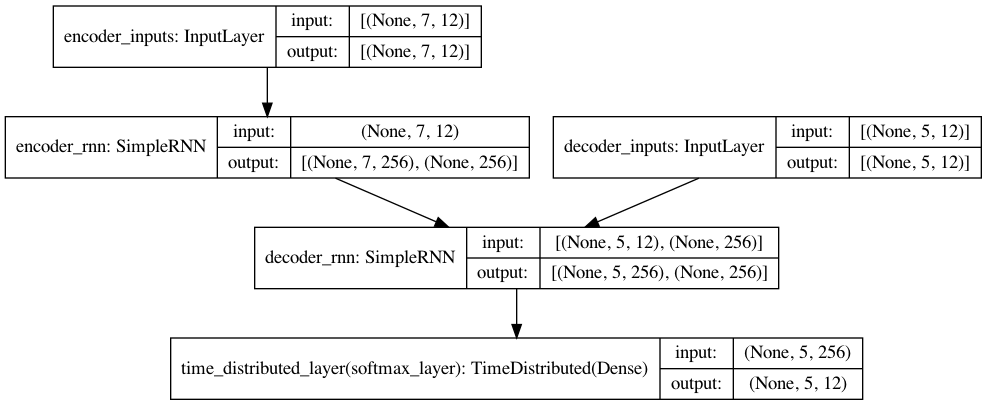

In [26]:
plot_model(full_model1, show_shapes=True)

### Training

In [27]:
# Run training
full_model1.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history1 = full_model1.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/30
282/282 [==============================] - 6s 18ms/step - loss: 1.4381 - accuracy: 0.4772 - val_loss: 1.2027 - val_accuracy: 0.5463
Epoch 2/30
282/282 [==============================] - 4s 14ms/step - loss: 1.1515 - accuracy: 0.5703 - val_loss: 1.0187 - val_accuracy: 0.6145
Epoch 3/30
282/282 [==============================] - 4s 13ms/step - loss: 0.9641 - accuracy: 0.6353 - val_loss: 0.8675 - val_accuracy: 0.6631
Epoch 4/30
282/282 [==============================] - 4s 13ms/step - loss: 0.7778 - accuracy: 0.7006 - val_loss: 0.6676 - val_accuracy: 0.7382
Epoch 5/30
282/282 [==============================] - 4s 13ms/step - loss: 0.6133 - accuracy: 0.7656 - val_loss: 0.5297 - val_accuracy: 0.7950
Epoch 6/30
282/282 [==============================] - 4s 13ms/step - loss: 0.4924 - accuracy: 0.8125 - val_loss: 0.4788 - val_accuracy: 0.8073
Epoch 7/30
282/282 [==============================] - 4s 13ms/step - loss: 0.4017 - accuracy: 0.8469 - val_loss: 0.3664 - val_accuracy: 0.8606

## Model 2 (GRU)

### Define Model

- Important highlights:
    - In Model 2, we replace vanilla RNN with GRU, which deals with the issue of long-distance dependencies between sequences.
    - You can try LSTM as well.

In [28]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder GRU
    ## first return is the hidden states of all timesteps of encoder
    ## second return is the last hidden state of encoder
encoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='encoder_gru')
_, encoder_state = encoder_gru(encoder_inputs)

# Decoder RNN
    ## using `encoder_state` (last h) as initial state.
    ## using `decoder_inputs` for teacher forcing learning
decoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model2 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 12)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 12)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 207360      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 207360      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

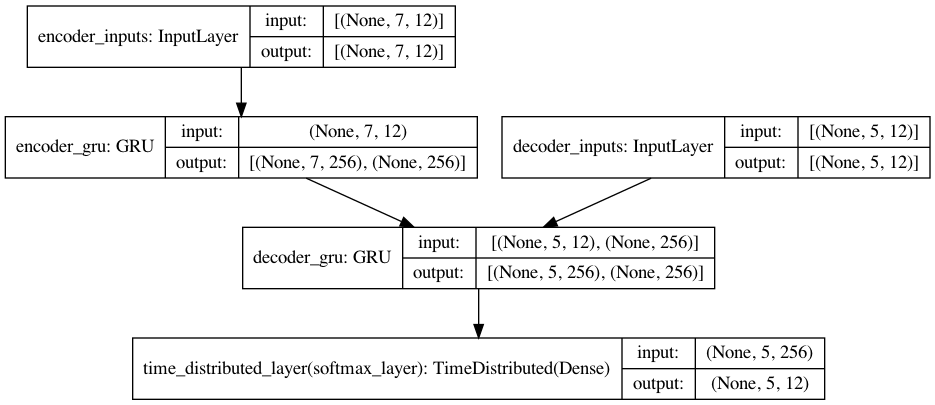

In [29]:
plot_model(full_model2, show_shapes=True)

### Training

In [30]:
# Run training
full_model2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history2 = full_model2.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/30
282/282 [==============================] - 15s 41ms/step - loss: 1.6741 - accuracy: 0.4298 - val_loss: 1.3807 - val_accuracy: 0.4797
Epoch 2/30
282/282 [==============================] - 10s 37ms/step - loss: 1.3570 - accuracy: 0.4876 - val_loss: 1.2359 - val_accuracy: 0.5358
Epoch 3/30
282/282 [==============================] - 10s 37ms/step - loss: 1.1740 - accuracy: 0.5549 - val_loss: 1.0431 - val_accuracy: 0.6041
Epoch 4/30
282/282 [==============================] - 11s 38ms/step - loss: 1.0069 - accuracy: 0.6182 - val_loss: 0.9273 - val_accuracy: 0.6492
Epoch 5/30
282/282 [==============================] - 11s 38ms/step - loss: 0.8949 - accuracy: 0.6601 - val_loss: 0.8019 - val_accuracy: 0.6991
Epoch 6/30
282/282 [==============================] - 11s 38ms/step - loss: 0.7825 - accuracy: 0.7055 - val_loss: 0.7418 - val_accuracy: 0.7175
Epoch 7/30
282/282 [==============================] - 11s 37ms/step - loss: 0.7193 - accuracy: 0.7296 - val_loss: 0.6848 - val_accuracy:

## Model 3 (Birdirectional)

![](../images/seq2seq-bidirectional.jpeg)

### Define Model

- Important highlights:
    - In Model 3, we implement a bi-directional Encoder.
    - At each encoding step, there will be two hidden states (i.e., forward and backward passes)

In [31]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder GRU
encoder_gru = Bidirectional(
    GRU(latent_dim,
        return_sequences=True,
        return_state=True,
        name='encoder_gru'))
_, encoder_state_fwd, encoder_state_bwd = encoder_gru(encoder_inputs)

# Combine forward and backward state (last h's) from encoder
encoder_state = Concatenate(axis=-1)([encoder_state_fwd, encoder_state_bwd])

# Decoder GRU
    # using `encoder_state` as initial state
    # the latent_dim *2 because we use two last states from the bidirectional encoder
decoder_gru = GRU(latent_dim * 2,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model3 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 12)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 7, 512), (No 414720      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 12)]      0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           bidirectional[0][1]              
                                                                 bidirectional[0][2]        

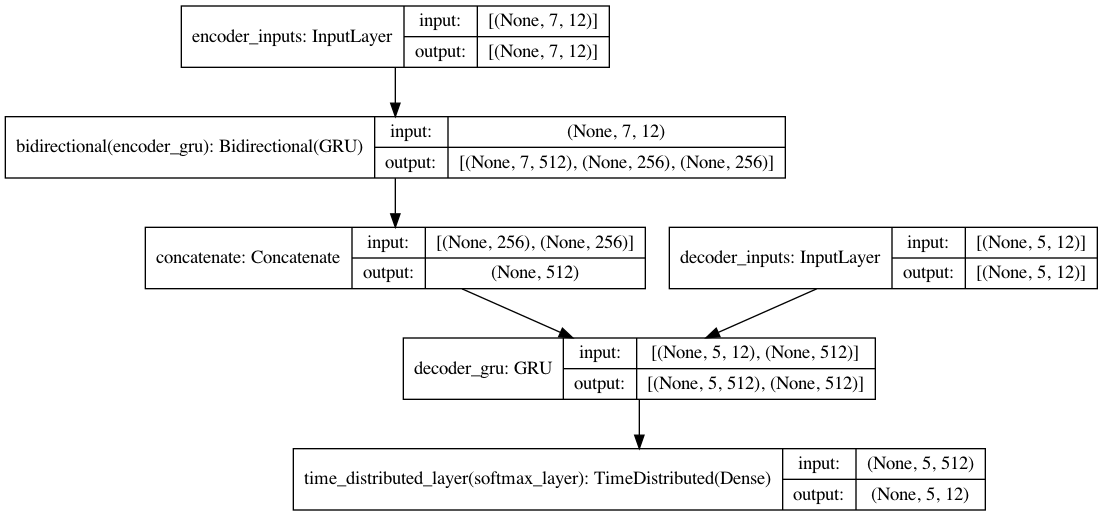

In [32]:
plot_model(full_model3, show_shapes=True)

### Training

In [33]:
# Run training
full_model3.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history3 = full_model3.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/30
282/282 [==============================] - 33s 103ms/step - loss: 1.6079 - accuracy: 0.4403 - val_loss: 1.3156 - val_accuracy: 0.5128
Epoch 2/30
282/282 [==============================] - 27s 95ms/step - loss: 1.1885 - accuracy: 0.5518 - val_loss: 0.9492 - val_accuracy: 0.6399
Epoch 3/30
282/282 [==============================] - 27s 97ms/step - loss: 0.8935 - accuracy: 0.6571 - val_loss: 0.7808 - val_accuracy: 0.6945
Epoch 4/30
282/282 [==============================] - 27s 97ms/step - loss: 0.7333 - accuracy: 0.7202 - val_loss: 0.6747 - val_accuracy: 0.7417
Epoch 5/30
282/282 [==============================] - 28s 99ms/step - loss: 0.6354 - accuracy: 0.7590 - val_loss: 0.5728 - val_accuracy: 0.7769
Epoch 6/30
282/282 [==============================] - 27s 97ms/step - loss: 0.5219 - accuracy: 0.8037 - val_loss: 0.4832 - val_accuracy: 0.8168
Epoch 7/30
282/282 [==============================] - 28s 99ms/step - loss: 0.4519 - accuracy: 0.8306 - val_loss: 0.4275 - val_accuracy

## Model 4 (Peeky Decoder)

![](../images/seq2seq-peeky.jpeg)

### Define Model

- Important highlights:
    - In the previous models, Decoder only utilizes Encoder's last hidden state for the decoding of the **first** output. As for the subsequent decoding time steps, Decoder does not have any information from Encoder.
    - In Model 4, we implement a **peeky** Decoder. This strategy allows Decoder to access the information (last hidden state) of the Encoder in every decoding time step.

In [34]:
# Define Model Inputs
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')

# Encoder GRU
encoder_gru = Bidirectional(
    GRU(latent_dim,
        return_sequences=True,
        return_state=True,
        name='encoder_gru'))
_, encoder_state_fwd, encoder_state_bwd = encoder_gru(encoder_inputs)

# Combine forward and backward state (last h's) from encoder
encoder_state = Concatenate(axis=-1)([encoder_state_fwd, encoder_state_bwd])


# Repeat the last-hidden-state of Encoder
encoder_state_repeated = RepeatVector(target_maxlen - 1)(encoder_state)

## Concatenate every decoder input with the encoder_state
decoder_inputs_peeky = Concatenate(axis=2)(
    [decoder_inputs, encoder_state_repeated])

# Decoder GRU
decoder_gru = GRU(latent_dim * 2,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, _ = decoder_gru(decoder_inputs_peeky, initial_state=encoder_state)

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_out)

# Full model
full_model4 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)

full_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 12)]      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 7, 512), (No 414720      encoder_inputs[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][2]            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 12)]      0                                      

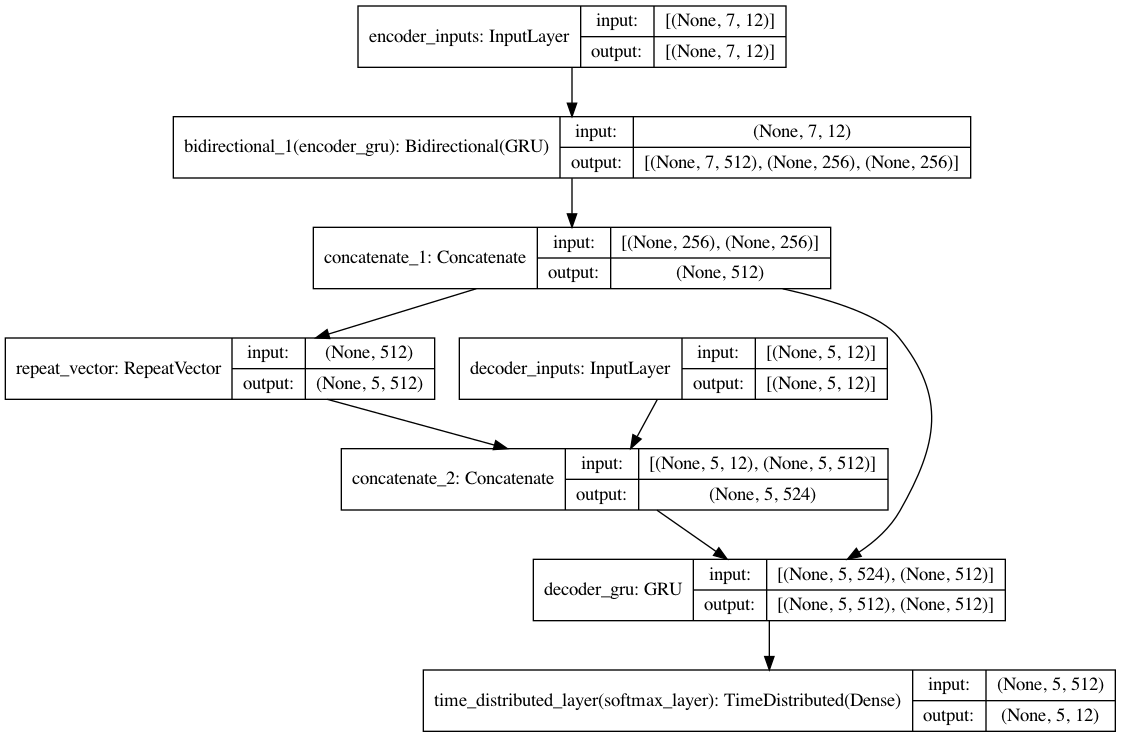

In [35]:
plot_model(full_model4, show_shapes=True)

### Training

In [36]:
# Run training
full_model4.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history4 = full_model4.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/30
282/282 [==============================] - 50s 162ms/step - loss: 1.5986 - accuracy: 0.4271 - val_loss: 1.2786 - val_accuracy: 0.5222
Epoch 2/30
282/282 [==============================] - 42s 150ms/step - loss: 1.1654 - accuracy: 0.5591 - val_loss: 0.9077 - val_accuracy: 0.6633
Epoch 3/30
282/282 [==============================] - 43s 151ms/step - loss: 0.8362 - accuracy: 0.6821 - val_loss: 0.6661 - val_accuracy: 0.7411
Epoch 4/30
282/282 [==============================] - 41s 146ms/step - loss: 0.6143 - accuracy: 0.7663 - val_loss: 0.4927 - val_accuracy: 0.8118
Epoch 5/30
282/282 [==============================] - 41s 147ms/step - loss: 0.4099 - accuracy: 0.8465 - val_loss: 0.2593 - val_accuracy: 0.9028
Epoch 6/30
282/282 [==============================] - 42s 147ms/step - loss: 0.1960 - accuracy: 0.9337 - val_loss: 0.1425 - val_accuracy: 0.9537
Epoch 7/30
282/282 [==============================] - 41s 146ms/step - loss: 0.1075 - accuracy: 0.9707 - val_loss: 0.1618 - val_ac

## Model 5 (Attention)

### Define Model

- Important highlights:
    - In Model 5, we implement an Attention-based Decoder.
    - This Attention mechanism allows the Decoder to use Encoder's all hidden states.

![](../images/seq2seq-attention-weights.jpeg)

In [37]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(input_maxlen, input_vsize),
                       name='encoder_inputs')
decoder_inputs = Input(shape=(target_maxlen - 1, target_vsize),
                       name='decoder_inputs')
# Encoder GRU
encoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='encoder_gru')
encoder_out, encoder_state = encoder_gru(encoder_inputs)

# Decoder GRU
decoder_gru = GRU(latent_dim,
                  return_sequences=True,
                  return_state=True,
                  name='decoder_gru')
decoder_out, decoder_state = decoder_gru(decoder_inputs,
                                         initial_state=encoder_state)

# Attention layer
attn_layer = Attention(name="attention_layer")

## The inputs for Attention:
##  `query`: the `decoder_out` = decoder's hidden state at the decoding step
##  `value` & `key`: the `encoder_out` = encoder's all hidden states
## It returns a tensor of shape as `query`, i.e., context tensor

attn_out, attn_weights = attn_layer([decoder_out, encoder_out],
                                    return_attention_scores=True)

# Concat context tensor + decoder_out
decoder_concat_input = Concatenate(
    axis=-1, name='concat_layer')([decoder_out, attn_out])

# Dense layer
dense = Dense(target_vsize, activation='softmax', name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(decoder_concat_input)

# Full model
full_model5 = Model(inputs=[encoder_inputs, decoder_inputs],
                    outputs=decoder_pred)
full_model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 12)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 12)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 207360      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 207360      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

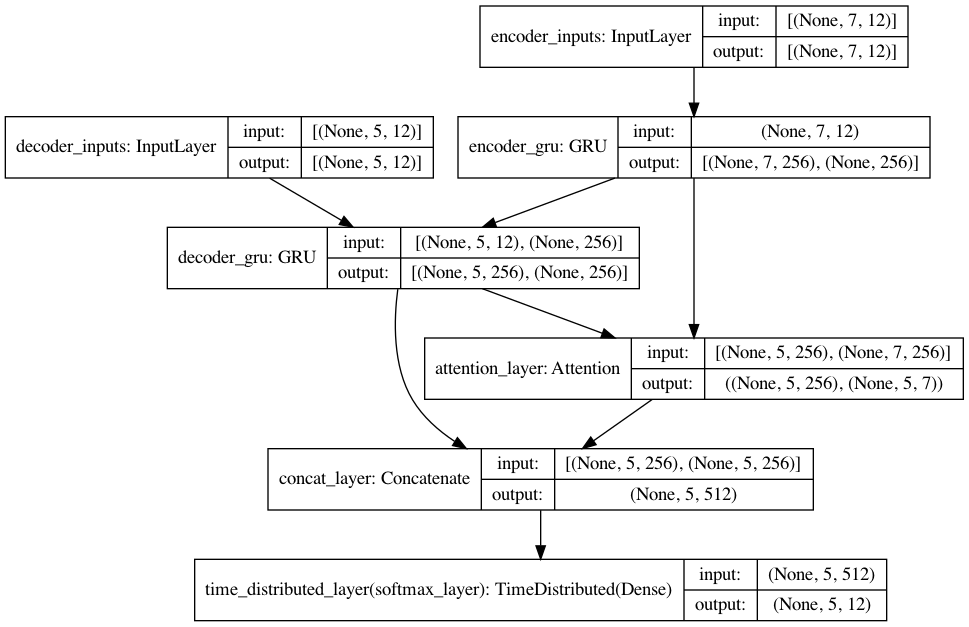

In [38]:
plot_model(full_model5, show_shapes=True)

### Training

In [39]:
# Run training
full_model5.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
history5 = full_model5.fit([encoder_input_onehot, decoder_input_onehot],
                           decoder_output_onehot,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_split=0.2)

Epoch 1/30
282/282 [==============================] - 15s 42ms/step - loss: 1.6877 - accuracy: 0.4021 - val_loss: 1.3822 - val_accuracy: 0.4808
Epoch 2/30
282/282 [==============================] - 11s 39ms/step - loss: 1.3569 - accuracy: 0.4933 - val_loss: 1.2155 - val_accuracy: 0.5394
Epoch 3/30
282/282 [==============================] - 11s 39ms/step - loss: 1.1449 - accuracy: 0.5621 - val_loss: 1.0299 - val_accuracy: 0.6038
Epoch 4/30
282/282 [==============================] - 11s 39ms/step - loss: 1.0067 - accuracy: 0.6153 - val_loss: 0.9458 - val_accuracy: 0.6377
Epoch 5/30
282/282 [==============================] - 11s 39ms/step - loss: 0.9173 - accuracy: 0.6472 - val_loss: 0.8299 - val_accuracy: 0.6754
Epoch 6/30
282/282 [==============================] - 11s 39ms/step - loss: 0.8073 - accuracy: 0.6889 - val_loss: 0.7581 - val_accuracy: 0.7086
Epoch 7/30
282/282 [==============================] - 11s 39ms/step - loss: 0.7421 - accuracy: 0.7178 - val_loss: 0.7211 - val_accuracy:

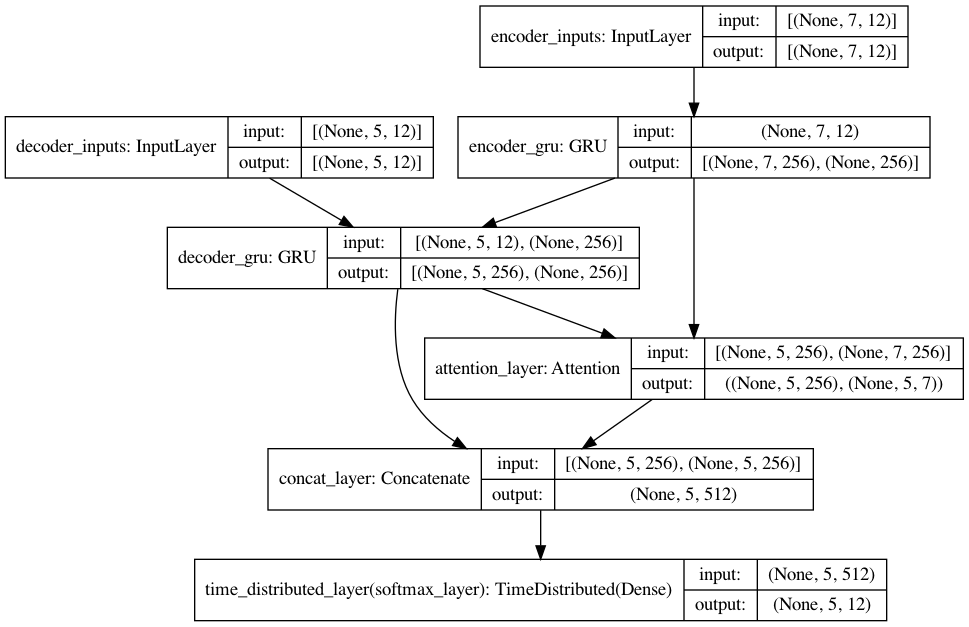

In [40]:
plot_model(full_model5, show_shapes=True)

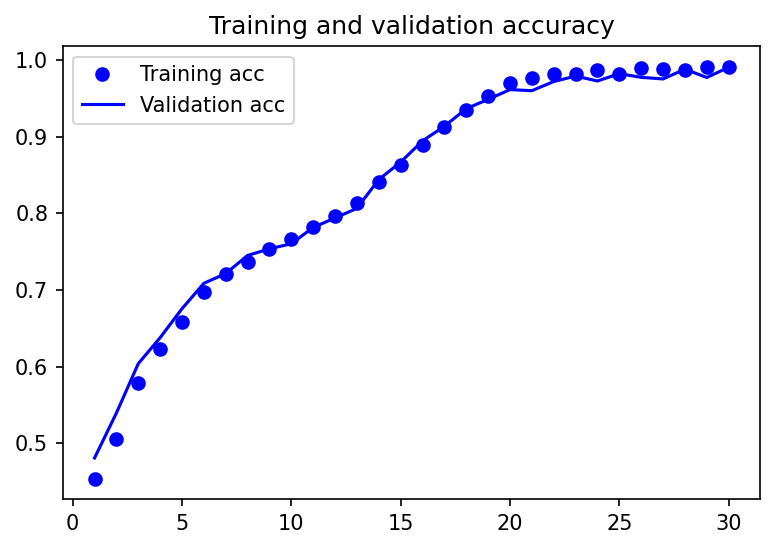

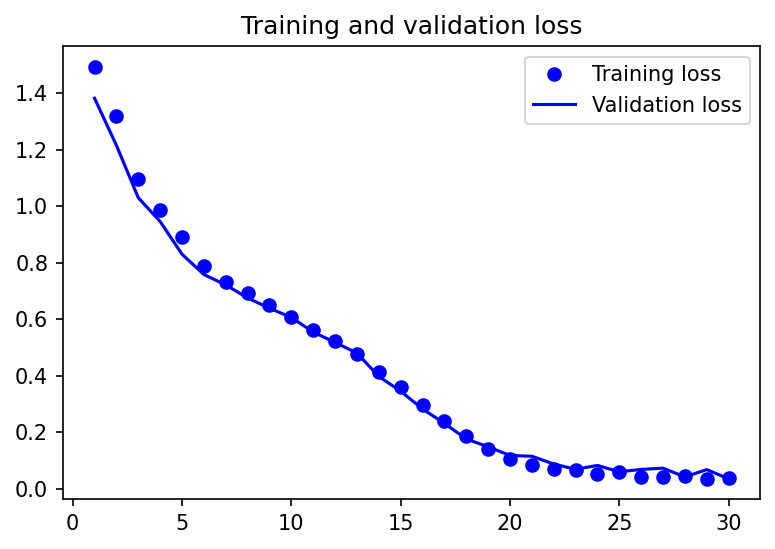

In [41]:
plot1(history5)

## Save Models

In [42]:
# # Save model
full_model5.save('keras_models/s2s-addition-attention.h5')

## Interim Comparison

In [43]:
history = [history1, history2, history3, history4, history5]
history = [i.history for i in history]
model_names = ['VanilaRNN', 'GRU', 'Birdirectional', 'Peeky', 'Attention']

In [44]:
# ## Saving all training histories
# import pickle
# with open('keras_models/s2s-attention-addition-history', 'wb') as f:
#     pickle.dump(history, f)
# with open('keras_models/s2s-attention-addition-history', 'rb') as f:
#     history = pickle.load(f)

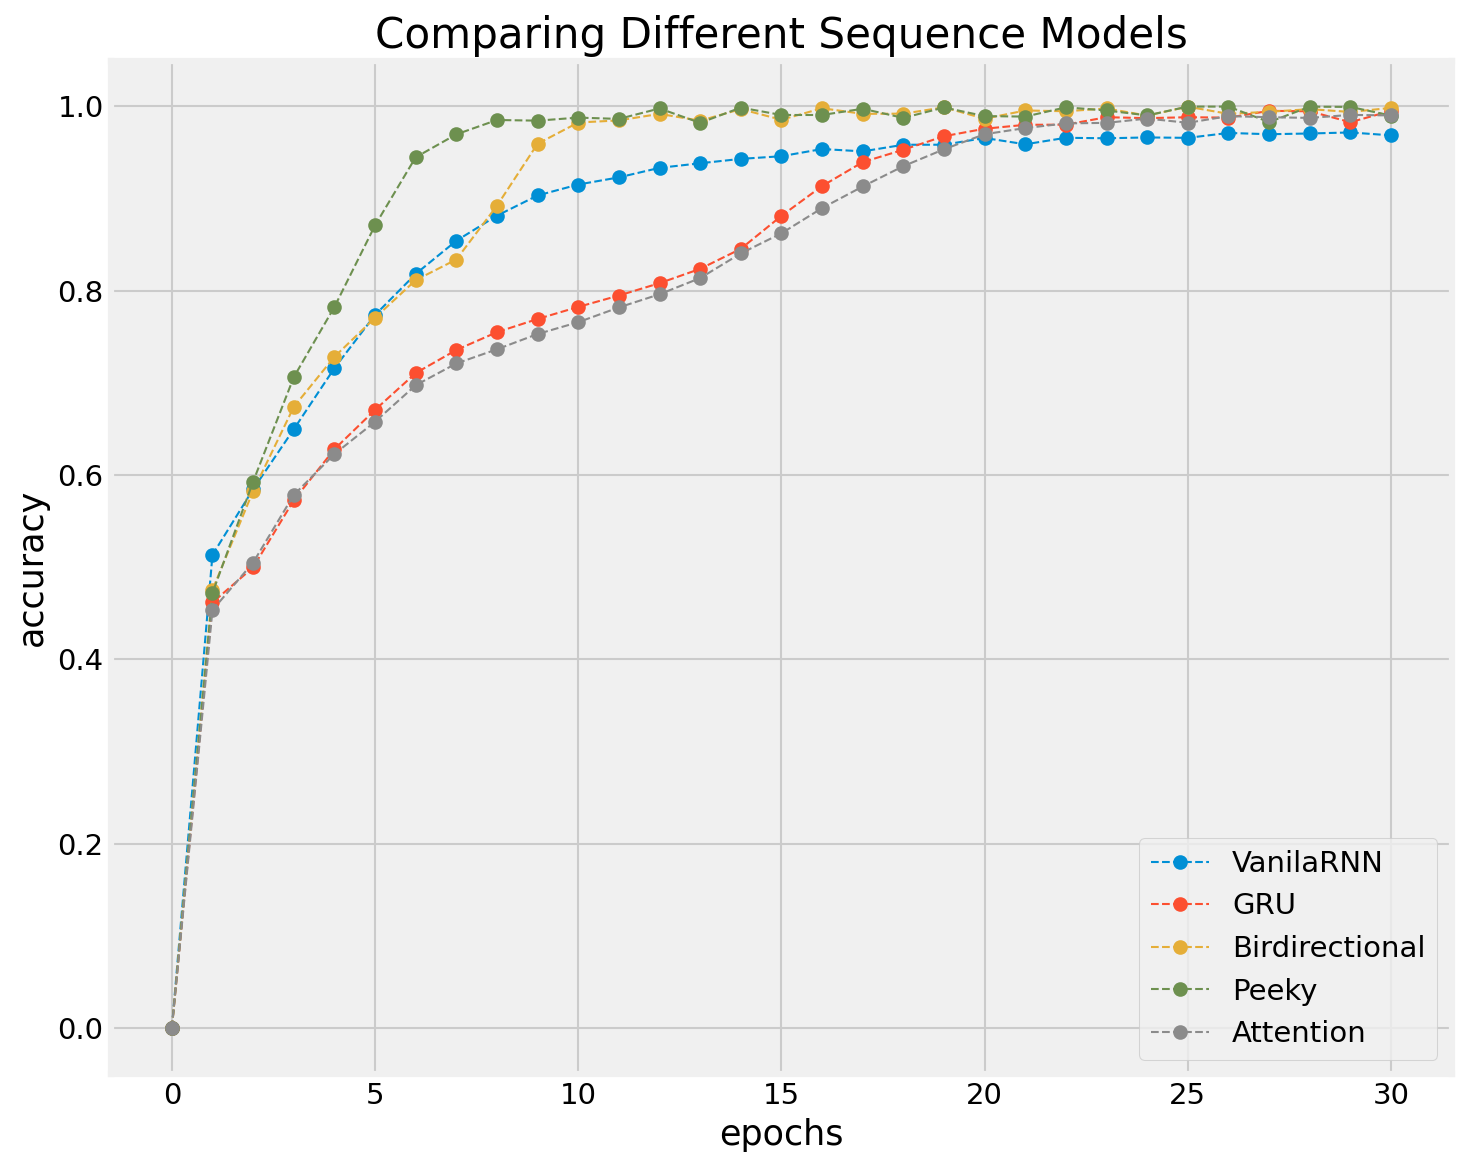

In [45]:
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

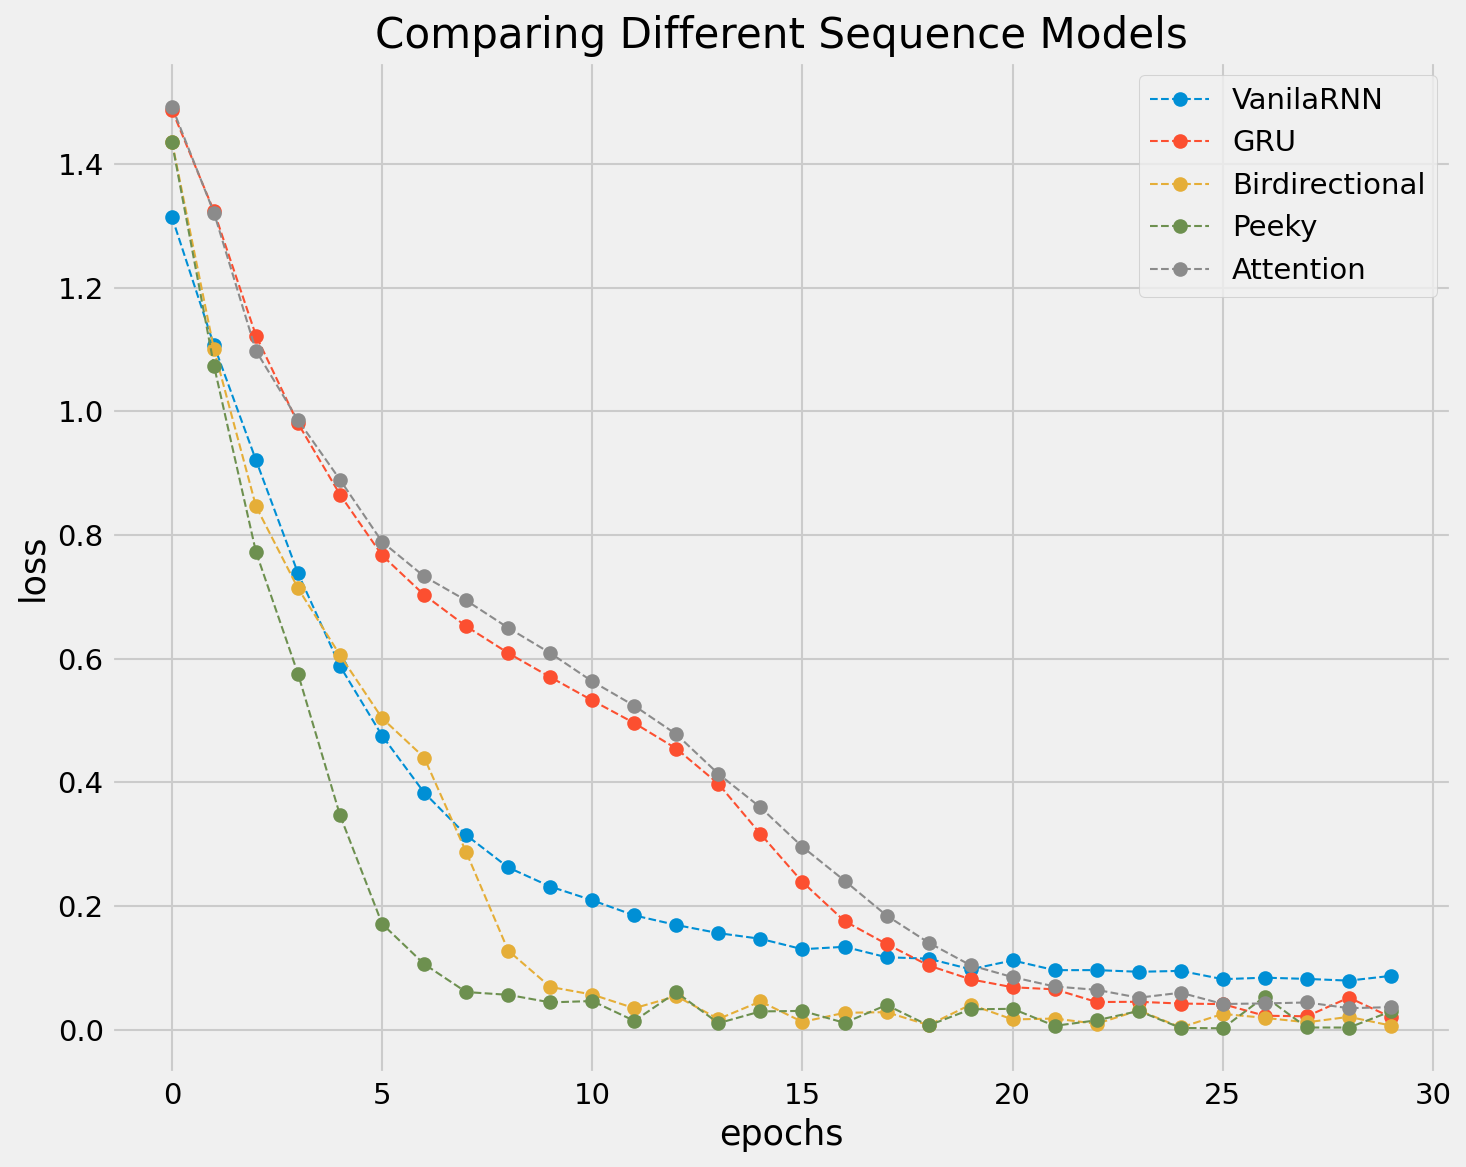

In [46]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('fivethirtyeight')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()

## Attention Model Analysis

In [47]:
# ## If the model is loaded via external files
# ## Load the encoder_model, decoder_model this way
# from keras.models import load_model
# full_model5.load_weights('keras_models/s2s-addition-attention.h5')
# full_model5.compile(optimizer='adam',
#                     loss='categorical_crossentropy',
#                     metrics=['accuracy'])

In [48]:
## Let's look at the attention-based model
full_model = full_model5

## Inference 

- At the inference stage, we use the trained model to decode input sequences.
- In decoding, it should be noted that Decoder would decode one word at a time.
- We set up **Inference-Encoder** and **Inference-Decoder** based on the trained model. We need to identify the right layer from the trained model for the use in inference.

In [49]:
full_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 7, 12)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 12)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(None, 7, 256), (No 207360      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, 5, 256), (No 207360      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

### Inference Encoder

In [50]:
## Inference-Encoder
encoder_inf_inputs = full_model.input[0]
encoder_inf_out, encoder_inf_state = full_model.layers[2].output
encoder_inf_model = Model(inputs=encoder_inf_inputs,
                          outputs=[encoder_inf_out, encoder_inf_state])

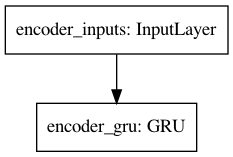

In [51]:
plot_model(encoder_inf_model)

### Inference Decoder

- Inference-Decoder requires two inputs:
    - Encoder's last hidden state as its initial hidden state
    - The input token of the target sequence (default start token: `_`)
- Inference-Attention requires two inputs:
    - Encoder's all hidden states as the **values** and **keys**
    - Inference-Decoder's hidden state as the **query**

In [52]:
## Inference-Decoder Input (1): The input token from the target sequence 
    ## one token at each time
    ## the default is the start token '_'
decoder_inf_inputs = Input(
    shape=(1, target_vsize),
    name='decoder_inf_inputs')  ## Initial Decoder's Output Token '_'

## Inference-Decoder Input (2): All hidden states from Inference-Encoder
encoder_inf_states = Input(
    shape=(input_maxlen, latent_dim),
    name='encoder_inf_states')

## Inference-Decoder Initial Hidden State = Inference-Encoder's last h
decoder_init_state = Input(shape=(latent_dim),
                           name='decoder_init')  ## initial c from encoder

## Inference-Decoder
decoder_inf_gru = full_model.layers[3]
decoder_inf_out, decoder_inf_state = decoder_inf_gru(
    decoder_inf_inputs, initial_state=decoder_init_state)


## Inference-Attention
decoder_inf_attention = full_model.layers[4]
attn_inf_out, attn_inf_weights = decoder_inf_attention(
    [decoder_inf_out, encoder_inf_states], return_attention_scores=True)

## Inference-Concatenate
decoder_inf_concat = Concatenate(
    axis=-1, name='concat')([decoder_inf_out, attn_inf_out])

## Inference-Dense
decoder_inf_timedense = full_model.layers[6]
decoder_inf_pred = decoder_inf_timedense(decoder_inf_concat)

## Inference-Model
decoder_inf_model = Model(
    inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
    outputs=[decoder_inf_pred, attn_inf_weights, decoder_inf_state])

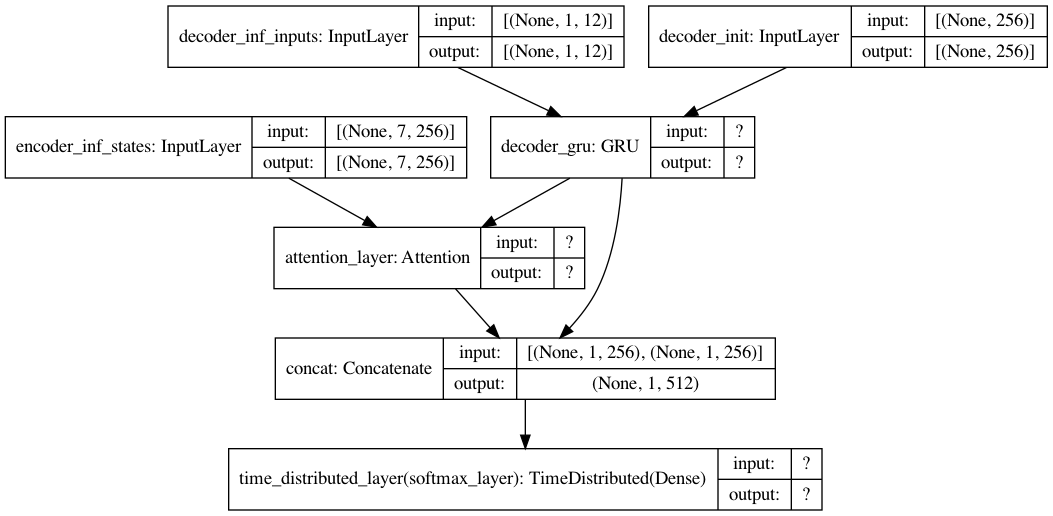

In [53]:
plot_model(decoder_inf_model, show_shapes=True)

### Decoding Input Sequences


- The Inference-Encoder processes the tokens of input sequences to get (a) all hidden states, and (b) the last hidden state.
- The Inference-Decoder uses the Inference-Encoder's last hidden state as the initial hidden state.
- The Inference-Decoder uses the token `_` as the initial token of the target sequence for decoding.
- At the subsequent decoding steps, Inference-Decoder updates its hidden state and the decoded token as inputs for the next-round decoding.
    

- Inference-Decoder is different from the training Decoder in that:
    - The latter takes in **all the correct target sequences** (i.e., `decoder_input_onehot`) for **teacher forcing**.
    - The former takes in **one** target token, which is predicted by the Inference-Decoder at the previous decoding step.

In [55]:
def decode_sequence(input_seq):

    ## Initialize target output character "_"
    initial_text = '_'
    initial_seq = target_tokenizer.texts_to_sequences(initial_text)
    test_dec_onehot_seq = np.expand_dims(
        to_categorical(initial_seq, num_classes=target_vsize), 1)

    ## Inference-Encoder processes input sequence
    enc_outs, enc_last_state = encoder_inf_model.predict(input_seq)

    ## Update Inference-Decoder initial hidden state
    dec_state = enc_last_state

    
    ## Holder for attention weights and decoded texts
    attention_weights = []
    dec_text = ''

    ## Inference-Decoder decoding step-by-step
    for i in range(target_maxlen):
        dec_out, attention, dec_state = decoder_inf_model.predict(
            [enc_outs, dec_state, test_dec_onehot_seq])
         
        ## Decoded Output (one-hot to integer)
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        ## Stopping Condition
        if dec_ind == 0:
            break

        ## Decoded Output (integer to char)
        initial_text = dec_index2word[dec_ind]
        
        ## Decoded Output for next-round decoding
        initial_seq = [dec_ind] #target_tokenizer.texts_to_sequences(initial_text)
        test_dec_onehot_seq = np.expand_dims(
            to_categorical(initial_seq, num_classes=target_vsize), 1)
        
        ## Keep track of attention weights for current decoded output
        attention_weights.append((dec_ind, attention))

        ## Append the predicted char
        dec_text += dec_index2word[dec_ind]

    return dec_text, attention_weights

In [56]:
## Test sequence-decoding function
## on first 20 training samples

for seq_index in range(20):
    decoded_sentence, _ = decode_sequence(
        encoder_input_onehot[seq_index:seq_index + 1, :, :])
    print('-')
    print('Input sentence:', tr_input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 27+673
Decoded sentence: 700_
-
Input sentence: 153+27
Decoded sentence: 180_
-
Input sentence: 93+901
Decoded sentence: 994_
-
Input sentence: 243+678
Decoded sentence: 921_
-
Input sentence: 269+46
Decoded sentence: 315_
-
Input sentence: 235+891
Decoded sentence: 1126_
-
Input sentence: 46+290
Decoded sentence: 336_
-
Input sentence: 324+947
Decoded sentence: 1271_
-
Input sentence: 721+49
Decoded sentence: 770_
-
Input sentence: 535+7
Decoded sentence: 542_
-
Input sentence: 45+117
Decoded sentence: 162_
-
Input sentence: 669+174
Decoded sentence: 843_
-
Input sentence: 904+7
Decoded sentence: 911_
-
Input sentence: 22+731
Decoded sentence: 753_
-
Input sentence: 83+742
Decoded sentence: 825_
-
Input sentence: 678+983
Decoded sentence: 1661_
-
Input sentence: 240+42
Decoded sentence: 282_
-
Input sentence: 18+44
Decoded sentence: 62_
-
Input sentence: 4+166
Decoded sentence: 170_
-
Input sentence: 731+13
Decoded sentence: 744_


## Plotting Attention

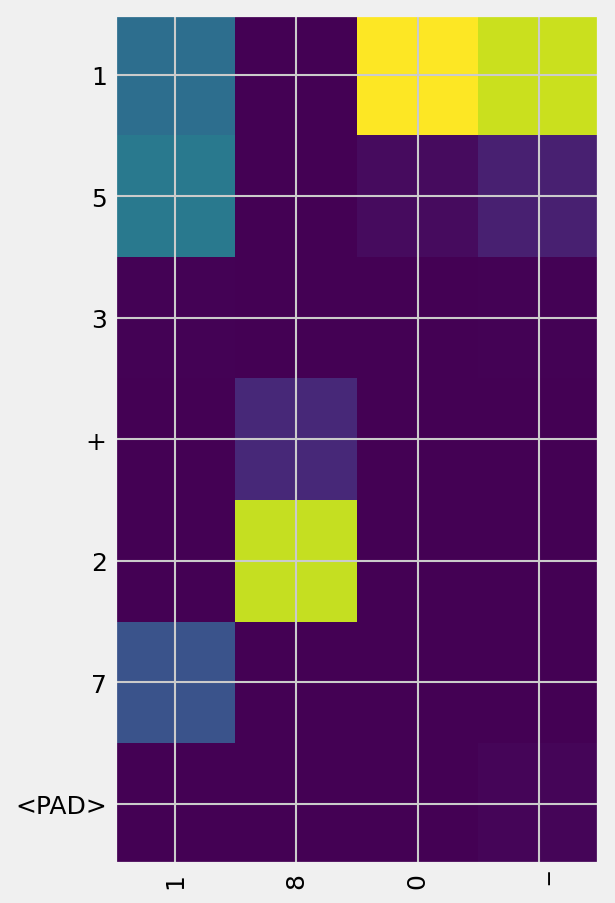

In [58]:
ind = 1

doc_inputs, attention_weights = decode_sequence(encoder_input_onehot[ind:ind +
                                                                     1, :, :])
mats = []
dec_inputs = []

for dec_ind, attn in attention_weights:
    mats.append(attn.reshape(-1))
    dec_inputs.append(dec_ind)

attention_mat = np.transpose(np.array(mats))
fig, ax = plt.subplots(figsize=(5, 7))
ax.imshow(attention_mat)

ax.set_xticks(np.arange(attention_mat.shape[1]))
ax.set_yticks(np.arange(attention_mat.shape[0]))

ax.set_xticklabels(
    [dec_index2word[inp] if inp != 0 else "<PAD>" for inp in dec_inputs])
ax.set_yticklabels([
    enc_index2word[inp] if inp != 0 else "<PAD>"
    for inp in encoder_input_sequences[ind]
])

ax.tick_params(labelsize=12)
ax.tick_params(axis='x', labelrotation=90)

## Evaluation on Testing Data

- Wrap text vectorization in a function.
- Vectorize the testing data in the same way as the training data
    - Texts to sequences
    - Pad sequences
    - One-hot encode sequences

In [59]:
def preprocess_data(enc_tokenizer, dec_tokenizer, enc_text, dec_text,
                    enc_maxlen, dec_maxlen, enc_vsize, dec_vsize):
    enc_seq = enc_tokenizer.texts_to_sequences(enc_text)
    enc_seq = pad_sequences(enc_seq, padding='post', maxlen=enc_maxlen)
    enc_onehot = to_categorical(enc_seq, num_classes=enc_vsize)

    dec_seq = dec_tokenizer.texts_to_sequences(dec_text)
    dec_seq = pad_sequences(dec_seq, padding='post', maxlen=dec_maxlen)
    dec_onehot = to_categorical(dec_seq, num_classes=dec_vsize)
    return enc_onehot, dec_onehot

In [60]:
ts_encoder_input_onehot, ts_decoder_target_onehot = preprocess_data(
    input_tokenizer, target_tokenizer, ts_input_texts, ts_target_texts,
    input_maxlen, target_maxlen, input_vsize, target_vsize)

In [61]:
print(ts_encoder_input_onehot.shape)
print(ts_decoder_target_onehot.shape)

(5000, 7, 12)
(5000, 6, 12)


In [62]:
full_model5.evaluate(
    [ts_encoder_input_onehot, ts_decoder_target_onehot[:, :-1, :]],
    ts_decoder_target_onehot[:, 1:, :],
    batch_size=batch_size,
    verbose=2)

40/40 - 1s - loss: 0.0353 - accuracy: 0.9894


[0.035290032625198364, 0.9894400238990784]

## References

- This unit is based on Chapter 7 of [Deep Learning 2用 Python 進行自然語言處理的基礎理論實作](https://www.tenlong.com.tw/products/9789865020675) and the original dataset is provided in the book and modified for this unit.